In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels
import matplotlib.pyplot as plt
import dodiscover as dod
import hyppo
import scipy as sp
import sklearn as sk
from sims import *

# Verifying balance function

In [2]:
n = 100
p=101
Ys, Ts, Xs, true_y, true_t, true_x = kclass_sim(n, p, causal_effect_size=3, balance=.4)

In [3]:
df = pd.DataFrame({"Batch": Ts, "y1" : Ys[:,0], "y2": Ys[:,p-1], "x" : Xs})
df_true = pd.DataFrame({"Batch" : true_t, "y1" : true_y[:, 0], "y2" : true_y[:, p-1], "x" : true_x})

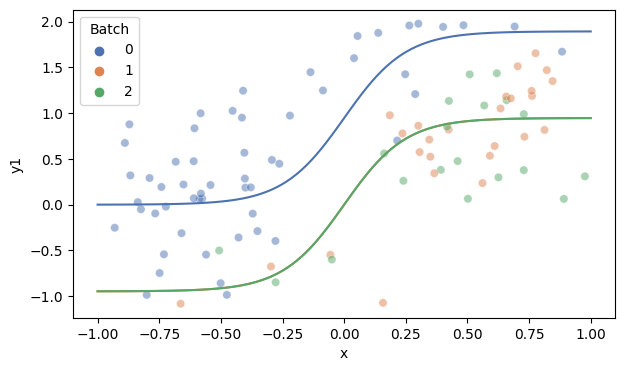

In [4]:
fig, ax = plt.subplots(1,1, figsize=(7, 4))
sns.scatterplot(data=df, x="x", y="y1", ax=ax, hue="Batch", alpha = 0.5, palette=sns.color_palette("deep", 3))
sns.lineplot(data=df_true, x="x", y="y1", ax=ax, hue="Batch", legend=False, palette=sns.color_palette("deep", 3));

<AxesSubplot: xlabel='x', ylabel='Count'>

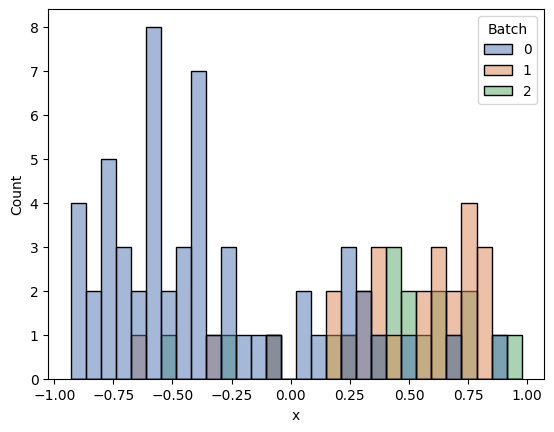

In [5]:
sns.histplot(data=df, x="x", hue="Batch", bins=30, palette=sns.color_palette("deep", 3))

In [6]:
balanced_ids = causal_prep(Xs, Ts)

Optimization terminated successfully.
         Current function value: 0.697436
         Iterations 6


In [7]:
Xs_bal = Xs[balanced_ids]; Ts_bal = Ts[balanced_ids]; Ys_bal = Ys[balanced_ids,:]
df_bal = pd.DataFrame({"Batch": Ts_bal, "y1" : Ys_bal[:,0], "y2": Ys_bal[:,p-1], "x" : Xs_bal})

<AxesSubplot: xlabel='x', ylabel='Count'>

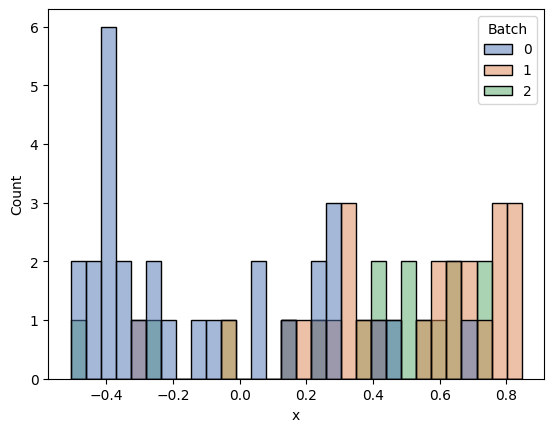

In [8]:
sns.histplot(data=df_bal, x="x", hue="Batch", bins=30, palette=sns.color_palette("deep", 3))

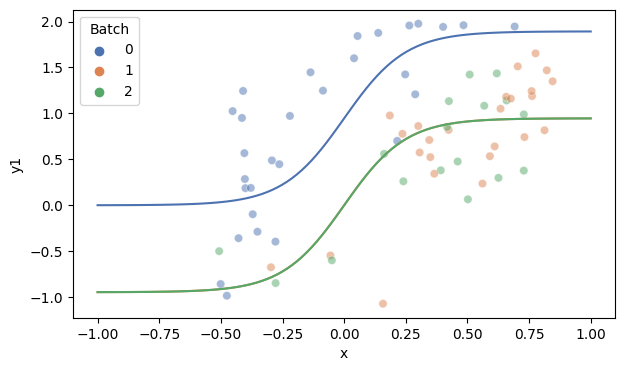

In [9]:
fig, ax = plt.subplots(1,1, figsize=(7, 4))
sns.scatterplot(data=df_bal, x="x", y="y1", hue="Batch", ax=ax, alpha=0.5, palette=sns.color_palette("deep", 3))
sns.lineplot(data=df_true, x="x", y="y1", ax=ax, hue="Batch", legend=False, palette=sns.color_palette("deep", 3));

# Covariate Fixed Sims

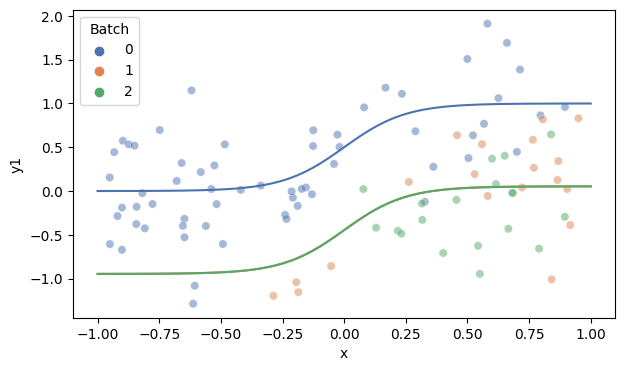

In [10]:
n = 100
p=101
Ys, Ts, Xs, true_y, true_t, true_x = kclass_sim(n, p, causal_effect_size=3, covar_effect_size=1, balance=.4)
df = pd.DataFrame({"Batch": Ts, "y1" : Ys[:,0], "y2": Ys[:,p-1], "x" : Xs})
df_true = pd.DataFrame({"Batch" : true_t, "y1" : true_y[:, 0], "y2" : true_y[:, p-1], "x" : true_x})
fig, ax = plt.subplots(1,1, figsize=(7, 4))
sns.scatterplot(data=df, x="x", y="y1", ax=ax, hue="Batch", alpha = 0.5, palette=sns.color_palette("deep", 3))
sns.lineplot(data=df_true, x="x", y="y1", ax=ax, hue="Batch", legend=False, palette=sns.color_palette("deep", 3));

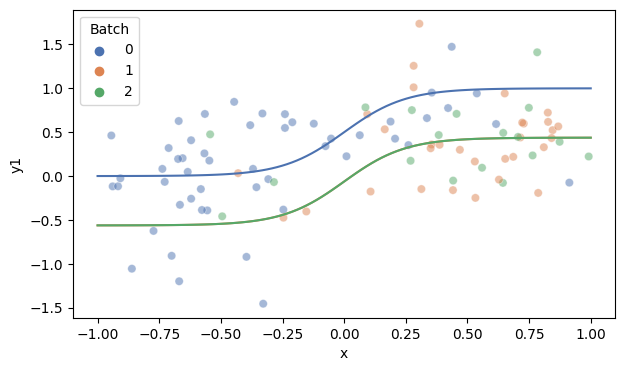

In [15]:
n = 100
p=101
Ys, Ts, Xs, true_y, true_t, true_x = kclass_sim(n, p, causal_effect_size=1, covar_effect_size=1, balance=.4)
df = pd.DataFrame({"Batch": Ts, "y1" : Ys[:,0], "y2": Ys[:,p-1], "x" : Xs})
df_true = pd.DataFrame({"Batch" : true_t, "y1" : true_y[:, 0], "y2" : true_y[:, p-1], "x" : true_x})
fig, ax = plt.subplots(1,1, figsize=(7, 4))
sns.scatterplot(data=df, x="x", y="y1", ax=ax, hue="Batch", alpha = 0.5, palette=sns.color_palette("deep", 3))
sns.lineplot(data=df_true, x="x", y="y1", ax=ax, hue="Batch", legend=False, palette=sns.color_palette("deep", 3));